In [1]:
import zipfile
zip_f="imdb_subset_10k_2k.zip"
directory=""
with zipfile.ZipFile(zip_f, 'r') as zip_ref:
        zip_ref.extractall(directory)

from datasets import load_from_disk
train_set = load_from_disk("/content/imdb_subset_10k_2k/train/")
test_set=load_from_disk("/content/imdb_subset_10k_2k/test/")


X_train,y_train=train_set["text"],train_set["label"]
X_test,y_test=test_set["text"],test_set["label"]

In [7]:
#PreProccessing del test
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
#remove stopwords and lemmatize X_train and X_test

X_train = [[lemmatizer.lemmatize(word) for word in review.split() if word not in stop_words] for review in X_train]
X_test = [[lemmatizer.lemmatize(word) for word in review.split() if word not in stop_words] for review in X_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [1]:
#make each element compatible with TDF-IDF
X_train = [' '.join(review) for review in X_train]
X_test = [' '.join(review) for review in X_test]

NameError: name 'X_train' is not defined

In [11]:
#Create a TDF-IF with scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_tfidf,y_train)
y_pred=rfc.predict(X_test_tfidf)


Accuracy:  0.8425
F1:  0.8405063291139241
Precision:  0.8512820512820513
Recall:  0.83


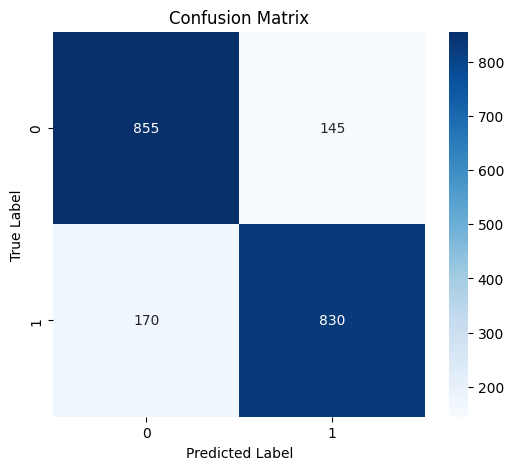

In [13]:
acc=accuracy_score(y_test,y_pred)
f1=f1_score(y_test,y_pred)
prec=precision_score(y_test,y_pred)
rec=recall_score(y_test,y_pred)
print("Accuracy: ",acc)
print("F1: ",f1)
print("Precision: ",prec)
print("Recall: ",rec)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Crea il plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [2]:
# Do this only in Colab notebooks! Otherwise use pip install unsloth
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [3]:
from unsloth import FastLanguageModel
import torch
from google.colab import userdata
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
models_name = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    "unsloth/Llama-3.2-3B-unsloth-bnb-4bit",
    "unsloth/Llama-3.2-1B-bnb-4bit",
    # not pre quantized models
    "unsloth/Meta-Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.2-1B",
] # More models at https://huggingface.co/unsloth



model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = models_name[2],  #qui stiamo caricando un modello quantizzato a 4bit
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = userdata.get('HF_LLAMA')  you need to request access to Llama models and use here your huggingface key
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],   #il modello degli embedding portarlo quando si adatta a un dominio specifico o a una nuova lingua
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

#in genere massimo 10 epoche bastano. Salvare ad ogni epoca e poi prendere il migliore

Unsloth 2025.5.7 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [32]:
#il modello base non ha mai visto prompt, quindi possiamo crearlo noi


inst_prompt = """Below is a question followed by a context of information that completes the question. Answer the question appropriately.

"Question: {question}\nContext: {context}\nAnswer: {answer}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    num_examples = len(examples["text"])
    questions_list = ["Classify the following review of a movie:"] * num_examples
    contexts_list = examples["text"]

    # Controlla se 'label' esiste prima di accedervi
    if "label" not in examples:
        # Gestisci il caso in cui 'label' non è presente, forse lancia un errore o usa un default
        # Per ora, creiamo una lista di placeholder se 'label' manca, anche se questo è un problema.
        print("Attenzione: colonna 'label' mancante nel batch!")
        answers_list = ["Unknown"] * num_examples
    else:
        answers_list = [label for label in examples["label"]]

    texts = []
    for q, c, a in zip(questions_list, contexts_list, answers_list):
        # Usare nomi di chiavi per inst_prompt.format per chiarezza
        text = inst_prompt.format(question=q, context=c, answer=a) + EOS_TOKEN
        texts.append(text)

    return { "text": texts } # Crea una nuova colonna, non sovrascrivere "text"


path_to_train_arrow_file = "/content/imdb_subset_10k_2k/train/data-00000-of-00001.arrow"
path_to_test_arrow_file = "/content/imdb_subset_10k_2k/test/data-00000-of-00001.arrow" # Adatta il nome del file se diverso

# Carica il training set
train_set = load_dataset(
    "arrow",  # Formato corretto
    data_files={"train": path_to_train_arrow_file},  # Dizionario che mappa lo split al file
    split="train"
)

# Carica il test set
test_set = load_dataset(
    "arrow",  # Formato corretto
    data_files={"test": path_to_test_arrow_file},  # Dizionario che mappa lo split al file
    split="test"  # Split corretto
)



train_set = train_set.map(formatting_prompts_func, batched = True, remove_columns=[ "text"] )
test_set = test_set.map(formatting_prompts_func, batched = True, remove_columns=["text"] )

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [33]:
train_set[0]

{'text': 'Below is a question followed by a context of information that completes the question. Answer the question appropriately.\n\n"Question: Classify the following review of a movie:\nContext: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...\nAnswer: 1<|end_of_text|>',
 'label': 1}

In [34]:
import xformers
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
#trl libreria di huggingface, la stiamo usando insieme ad unsloth
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_set,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,   #unsloth la gestisce in maniera dinamica
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.  (permette di concatenare piu esempi di training insieme, trianing piu veloce ma esempi MOOOLTO corti, fa schifo)
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        #un batch sarà da 16 quindi
        warmup_steps = 10,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 100,   #i passaggi di training
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 50,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

In [35]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 11,272,192/1,000,000,000 (1.13% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
50,2.768600
100,2.650400


In [52]:
test_set[0]["text"]
test_set[0]["label"]

1

#INFERENCE#

In [73]:
#for every element of the test_set, we give the text to the LLM, we take the answer, we compare if with the label and we computer accuracy, etc...
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
y_pred=[]
y_real=[]

FastLanguageModel.for_inference(model)
for i in tqdm(range(len(test_set))):
  element=test_set[i]
  y_real.append(element["label"])
  inputs = tokenizer(element["text"], return_tensors = "pt").to("cuda")
  outputs = model.generate(**inputs, max_new_tokens = 1, use_cache = True)
  #from output take the character before end of text token
  answer=tokenizer.decode(outputs[0][:-1]).split("Answer: ")[1]
  y_pred.append(int(answer.replace("<|end_of_text|>","")))

#print first 10 elements of y_pred
print(y_pred[0])


  0%|          | 0/2000 [00:00<?, ?it/s]

Unsloth: Input IDs of length 2958 > the model's max sequence length of 2048.
We shall truncate it ourselves. It's imperative if you correct this issue first.


1


In [68]:
y_pred[1]

1

Accuracy:  1.0
F1:  1.0
Precision:  1.0
Recall:  1.0


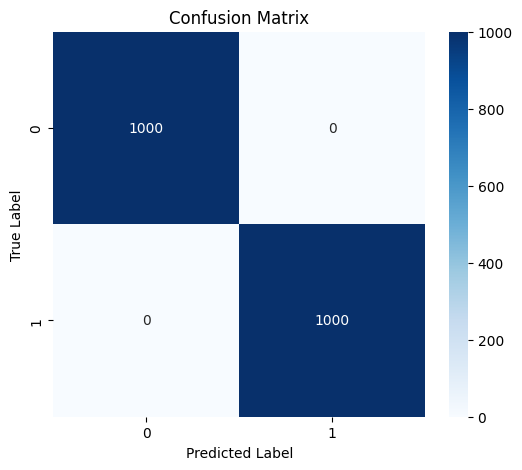

In [75]:
acc=accuracy_score(y_real,y_pred)
f1=f1_score(y_real,y_pred)
prec=precision_score(y_real,y_pred)
rec=recall_score(y_real,y_pred)
cm = confusion_matrix(y_real, y_pred)
print("Accuracy: ",acc)
print("F1: ",f1)
print("Precision: ",prec)
print("Recall: ",rec)
import matplotlib.pyplot as plt
import seaborn as sns
# Crea il plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()